In [1]:
import os
import sys

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../')
os.getcwd()

'/home/lehl/development/QueryOptDeepDive'

In [11]:
from src.database.postgres_executor import PostgresExecutor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os

## Run experiment: Execute every JOB query N times each in succession

In [26]:
"""
exec.close_connection()
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload')    
"""

Now connected to imdbload!


In [27]:
"""
exec.execute('SET enable_bao TO off')

data = []
for i, query in enumerate(os.listdir('bao/queries/join-order-benchmark')):
    if not '.sql' in query:
        continue
        
    print(f'[{i+1} / 113] Running query {query}...', end='')
        
    file_path = os.path.join('bao/queries/join-order-benchmark', query)
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
    sql_query = ' '.join(lines)
    sql_query = f"EXPLAIN (ANALYZE, VERBOSE, FORMAT JSON)\n{sql_query}"
    
    for q_i in range(5):
        res = exec.execute(sql_query).fetchall()
        exec_time = res[0][0][0]['Execution Time']
        
        data.append({
            'query': query,
            'exec_time': exec_time,
            'iteration': q_i
        })
        
    print('done')
    print('\t', [x['exec_time'] for x in data[-5:]])
        
    
"""

[1 / 113] Running query 22b.sql...done
	 [292.911, 214.033, 210.46, 222.5, 210.107]
[2 / 113] Running query 33a.sql...done
	 [34.308, 28.921, 30.503, 32.513, 29.271]
[3 / 113] Running query 31c.sql...done
	 [1197.205, 1178.273, 1216.259, 1105.1, 1145.107]
[4 / 113] Running query 14c.sql...done
	 [518.49, 450.254, 447.616, 451.029, 453.709]
[5 / 113] Running query 16d.sql...done
	 [1304.505, 1168.061, 1170.061, 1178.936, 1187.4]
[6 / 113] Running query 17d.sql...done
	 [5722.957, 5583.866, 5478.909, 5512.006, 5322.948]
[7 / 113] Running query 17c.sql...done
	 [5175.543, 5266.69, 5112.46, 5148.412, 5245.455]
[8 / 113] Running query 19b.sql...done
	 [130.635, 120.696, 124.689, 126.767, 127.907]
[9 / 113] Running query 1d.sql...done
	 [102.659, 99.75, 103.486, 101.311, 104.683]
[10 / 113] Running query 10b.sql...done
	 [225.445, 222.669, 231.034, 211.057, 217.538]
[11 / 113] Running query 5b.sql...done
	 [124.185, 124.606, 124.7, 126.104, 125.453]
[12 / 113] Running query 25b.sql...done
	 

[95 / 113] Running query 15d.sql...done
	 [594.075, 562.885, 554.561, 557.116, 533.19]
[96 / 113] Running query 13d.sql...done
	 [2166.58, 2126.706, 2135.079, 2109.433, 2161.291]
[97 / 113] Running query 16b.sql...done
	 [18586.659, 18282.122, 18282.617, 18336.189, 18759.834]
[98 / 113] Running query 17e.sql...done
	 [10257.883, 10253.399, 10477.333, 10105.171, 10430.158]
[99 / 113] Running query 14a.sql...done
	 [234.678, 219.55, 221.609, 220.449, 222.058]
[100 / 113] Running query 13c.sql...done
	 [671.561, 680.244, 663.9, 668.399, 573.005]
[101 / 113] Running query 15a.sql...done
	 [318.323, 295.766, 290.864, 324.871, 288.554]
[102 / 113] Running query 17f.sql...done
	 [9068.379, 8443.776, 8304.823, 8267.8, 8186.445]
[104 / 113] Running query 7c.sql...done
	 [1248.782, 1237.928, 1212.143, 1220.148, 1199.026]
[105 / 113] Running query 23b.sql...done
	 [48.927, 49.042, 62.242, 45.99, 47.607]
[106 / 113] Running query 26b.sql...done
	 [106.464, 101.053, 97.158, 97.927, 97.125]
[107 / 1

## Prepare experiment results 

In [12]:
def fix_query_ident(x):
    x = x.split('.sql')[0]
    id = x[-1]
    base_query = x[:-1]
    return f"{str(base_query).zfill(2)}{id}"

In [13]:
with open('bao/logs/older_experiments/pg__imdb__50.txt') as f:
    lines = f.readlines()
    
data = []
for line in lines:
    if len(line.split(' ')) == 7:
        _, i, date, time, query, exec_time, _ = line.split(' ')
        data.append({
            'date': date,
            'time': time,
            'iteration': int(i),
            'query_ident': fix_query_ident(query.split('/')[-1]),
            'exec_time': float(exec_time)
        })
        
df = pd.DataFrame(data).sort_values(['query_ident', 'iteration']).reset_index(drop=True)

intervals = []
for query, df_group in df.groupby(['query_ident']):
    conf_interval = 1.96 * np.std(df_group['exec_time'].tolist()) / np.sqrt(len(df_group['exec_time'].tolist()))
    intervals.append(conf_interval)

df['conv_interval'] = np.repeat(intervals, 50)
df['exec_time__normalized'] = df['exec_time'] / np.repeat(df[df['iteration'] == 0]['exec_time'].tolist(), 50)

df

/tmp/ipykernel_3685380/432128474.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for query, df_group in df.groupby(['query_ident']):


,date,time,iteration,query_ident,exec_time,conv_interval,exec_time__normalized
0,2023-06-09,09:05:29.829261,0,01a,104.313,2.974757,1.000000
1,2023-06-09,09:05:29.829349,1,01a,107.967,2.974757,1.035029
2,2023-06-09,09:05:29.829361,2,01a,113.258,2.974757,1.085752
3,2023-06-09,09:05:29.829368,3,01a,103.893,2.974757,0.995974
4,2023-06-09,09:05:29.829375,4,01a,101.644,2.974757,0.974414
...,...,...,...,...,...,...,...
5645,2023-06-09,11:29:11.743712,45,33c,13.479,0.693650,0.434414
5646,2023-06-09,11:29:11.743733,46,33c,14.589,0.693650,0.470188
5647,2023-06-09,11:29:11.743763,47,33c,13.480,0.693650,0.434446
5648,2023-06-09,11:29:11.743785,48,33c,14.278,0.693650,0.460165


In [14]:
data = []

for query_ident, df_group in df.groupby(['query_ident']):
    diff = df_group['exec_time'].max() - df_group['exec_time'].min()
    med = df_group['exec_time'].median()
    data.append({
        'query_ident': query_ident,
        'diff': diff,
        'rel_diff': diff/med,
        'conv_interval': df_group['conv_interval'].unique()[0]
    })
    #print(f"{query}:\t{diff:8.2f} ({diff/med:4.2f})")
    
df_diff = pd.DataFrame(data)
df_diff

/tmp/ipykernel_3685380/1750404708.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for query_ident, df_group in df.groupby(['query_ident']):


,query_ident,diff,rel_diff,conv_interval
0,01a,36.961,0.361157,2.974757
1,01b,34.309,0.360440,1.554677
2,01c,28.160,0.276745,1.605315
3,01d,46.347,0.482708,3.525801
4,02a,97.436,0.208221,4.090848
...,...,...,...,...
108,32a,4.359,0.406377,0.299692
109,32b,81.385,0.839743,4.185000
110,33a,8.914,0.693292,0.372586
111,33b,9.198,0.723881,0.376641


In [15]:
df_diff[df_diff['conv_interval'] < df_diff['diff']].sort_values(['diff'])

,query_ident,diff,rel_diff,conv_interval
108,32a,4.359,0.406377,0.299692
94,27b,5.036,0.323204,0.282441
19,06c,5.879,0.537779,0.286782
93,27a,6.315,0.244796,0.300628
95,27c,8.634,0.317660,0.452225
...,...,...,...,...
87,25a,530.210,0.436093,21.550909
70,19c,535.075,0.252027,40.067909
32,09c,895.989,0.429275,54.498553
101,29c,942.628,0.140947,49.787565


In [16]:
df2 = pd.DataFrame()
df2['query_ident'] = df['query_ident'].unique()
df2['0-1_norm'] = df[df['iteration'] == 1]['exec_time__normalized'].to_numpy() - df[df['iteration'] == 0]['exec_time__normalized'].to_numpy()
df2['0-2_norm'] = df[df['iteration'] == 2]['exec_time__normalized'].to_numpy() - df[df['iteration'] == 0]['exec_time__normalized'].to_numpy()
df2['0-3_norm'] = df[df['iteration'] == 3]['exec_time__normalized'].to_numpy() - df[df['iteration'] == 0]['exec_time__normalized'].to_numpy()
df2['0-4_norm'] = df[df['iteration'] == 4]['exec_time__normalized'].to_numpy() - df[df['iteration'] == 0]['exec_time__normalized'].to_numpy()
df2['1-2_norm'] = df[df['iteration'] == 2]['exec_time__normalized'].to_numpy() - df[df['iteration'] == 1]['exec_time__normalized'].to_numpy()
df2['2-3_norm'] = df[df['iteration'] == 3]['exec_time__normalized'].to_numpy() - df[df['iteration'] == 2]['exec_time__normalized'].to_numpy()
df2['3-4_norm'] = df[df['iteration'] == 4]['exec_time__normalized'].to_numpy() - df[df['iteration'] == 3]['exec_time__normalized'].to_numpy()
df2['0-1'] = df[df['iteration'] == 1]['exec_time'].to_numpy() - df[df['iteration'] == 0]['exec_time'].to_numpy()
df2['0-2'] = df[df['iteration'] == 2]['exec_time'].to_numpy() - df[df['iteration'] == 0]['exec_time'].to_numpy()
df2['0-3'] = df[df['iteration'] == 3]['exec_time'].to_numpy() - df[df['iteration'] == 0]['exec_time'].to_numpy()
df2['0-4'] = df[df['iteration'] == 4]['exec_time'].to_numpy() - df[df['iteration'] == 0]['exec_time'].to_numpy()
df2['1-2'] = df[df['iteration'] == 2]['exec_time'].to_numpy() - df[df['iteration'] == 1]['exec_time'].to_numpy()
df2['2-3'] = df[df['iteration'] == 3]['exec_time'].to_numpy() - df[df['iteration'] == 2]['exec_time'].to_numpy()
df2['3-4'] = df[df['iteration'] == 4]['exec_time'].to_numpy() - df[df['iteration'] == 3]['exec_time'].to_numpy()
df2

,query_ident,0-1_norm,0-2_norm,0-3_norm,0-4_norm,1-2_norm,2-3_norm,3-4_norm,0-1,0-2,0-3,0-4,1-2,2-3,3-4
0,01a,0.035029,0.085752,-0.004026,-0.025586,0.050722,-0.089778,-0.021560,3.654,8.945,-0.420,-2.669,5.291,-9.365,-2.249
1,01b,-0.019727,-0.002934,-0.032762,-0.073752,0.016793,-0.029828,-0.040990,-1.990,-0.296,-3.305,-7.440,1.694,-3.009,-4.135
2,01c,-0.079335,-0.074385,-0.093346,-0.090462,0.004949,-0.018960,0.002884,-8.720,-8.176,-10.260,-9.943,0.544,-2.084,0.317
3,01d,-0.219524,-0.199726,0.025534,-0.014773,0.019798,0.225260,-0.040307,-26.600,-24.201,3.094,-1.790,2.399,27.295,-4.884
4,02a,-0.142199,-0.108066,-0.143268,-0.122768,0.034132,-0.035202,0.020500,-78.035,-59.304,-78.622,-67.372,18.731,-19.318,11.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,32a,-0.217337,-0.257362,-0.164109,-0.264551,-0.040025,0.093253,-0.100442,-3.144,-3.723,-2.374,-3.827,-0.579,1.349,-1.453
109,32b,-0.400018,-0.401084,-0.405236,-0.425454,-0.001066,-0.004152,-0.020218,-64.935,-65.108,-65.782,-69.064,-0.173,-0.674,-3.282
110,33a,-0.370698,-0.388119,-0.387881,-0.408206,-0.017421,0.000238,-0.020325,-7.788,-8.154,-8.149,-8.576,-0.366,0.005,-0.427
111,33b,-0.409892,-0.408529,-0.415528,-0.412944,0.001362,-0.006998,0.002583,-8.727,-8.698,-8.847,-8.792,0.029,-0.149,0.055


## Plots for showing differences in successive execution times

STDDEV [13.64218449  4.9811239   5.50657331  5.90635174]
MEAN   [-14.55955396  -1.03035521   0.34079735   0.11259242]
MEDIAN [-1.19563461e+01 -9.95559581e-01 -6.55121783e-03  2.88407300e-01]


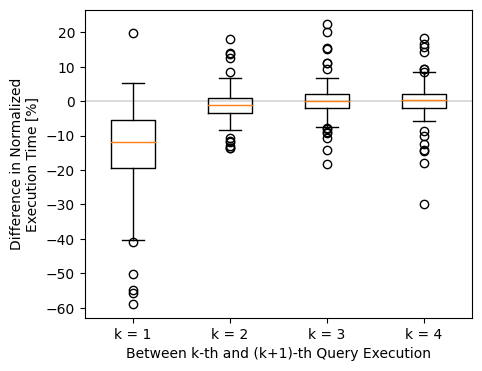

In [26]:
lbls = ['0-1', '1-2', '2-3', '3-4']
data = [100*np.array(df2[l + '_norm'].tolist()) for l in lbls]
print('STDDEV', np.std(data, axis=1))
print('MEAN  ', np.mean(data, axis=1))
print('MEDIAN', np.median(data, axis=1))

plt.figure(figsize=(5,4))
plt.plot([0.5, 4.5], [0, 0], color='black', linewidth=0.2)
plt.boxplot(data, labels=['k = 1', 'k = 2', 'k = 3', 'k = 4'])
plt.ylabel('Difference in Normalized\nExecution Time [%]')
plt.xlabel('Between k-th and (k+1)-th Query Execution')
plt.show()

STDDEV [13.64218449 13.99032543 13.88492065 14.11743398]
MEAN   [-14.55955396 -15.58990917 -15.24911181 -15.13651939]
MEDIAN [-11.95634615 -12.54085689 -12.99305408 -12.4928459 ]


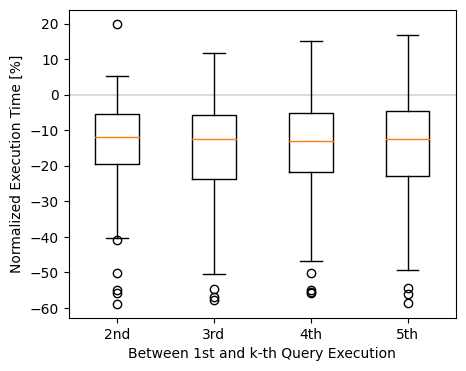

In [20]:
lbls = ['0-1', '0-2', '0-3', '0-4']
data = [100*np.array(df2[l + '_norm'].tolist()) for l in lbls]
#data = [df2[l].tolist() for l in lbls]
print('STDDEV', np.std(data, axis=1))
print('MEAN  ', np.mean(data, axis=1))
print('MEDIAN', np.median(data, axis=1))

plt.figure(figsize=(5,4))
plt.plot([0.5, 4.5], [0, 0], color='black', linewidth=0.2)
plt.boxplot(data, labels=['2nd', '3rd', '4th', '5th'])
plt.ylabel('Normalized Execution Time [%]')
plt.xlabel('Between 1st and k-th Query Execution')
#plt.ylim([-0.4, 0.4])
#plt.ylim([-200, 200])
plt.show()

### Visualize distribution of execution times

STDDEV [1327.74405791 1262.50032856 1257.77984618 1265.44542566 1276.06760092
 1249.11891244 1259.50891564 1261.63078978]
MEAN   [1024.11222124  943.93988496  939.94145133  940.60641593  944.24730088
  932.1259823   939.96444248  937.23737168]
MEDIAN [406.221 312.513 306.202 290.107 305.31  313.597 304.052 295.387]


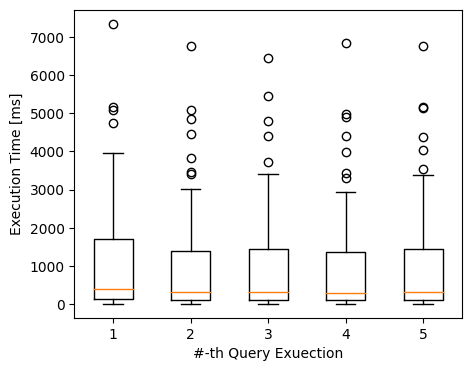

In [287]:
lbls = df['iteration'].unique()
data = [df[df['iteration'] == l]['exec_time'] for l in lbls]
print('STDDEV', np.std(data, axis=1)[:8])
print('MEAN  ', np.mean(data, axis=1)[:8])
print('MEDIAN', np.median(data, axis=1)[:8])

plt.figure(figsize=(5,4))
plt.boxplot(data[:5], labels=[x+1 for x in lbls][:5])
plt.ylabel('Execution Time [ms]')
plt.xlabel('#-th Query Exuection')
plt.show()

STDDEV [ 0.         13.64218449 13.99032543 13.88492065 14.11743398 13.98908283
 14.40400056 13.77068207]
MEAN   [100.          85.44044604  84.41009083  84.75088819  84.86348061
  84.31590876  84.77329024  84.67423657]
MEDIAN [100.          88.04365385  87.45914311  87.00694592  87.5071541
  86.81571453  87.29364504  87.43331655]


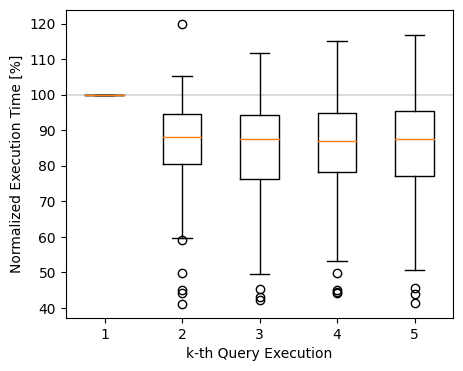

In [28]:
lbls = df['iteration'].unique()
data = [100*np.array(df[df['iteration'] == l]['exec_time__normalized']) for l in lbls]
print('STDDEV', np.std(data, axis=1)[:8])
print('MEAN  ', np.mean(data, axis=1)[:8])
print('MEDIAN', np.median(data, axis=1)[:8])

plt.figure(figsize=(5,4))
plt.plot([0.5, 5.5], [100, 100], color='black', linewidth=0.2)
plt.boxplot(data[:5], labels=[x+1 for x in lbls][:5])
plt.ylabel('Normalized Execution Time [%]')
plt.xlabel('k-th Query Execution')
plt.show()

## Showing, if there is a different between the first of a base query (A-variant) and others

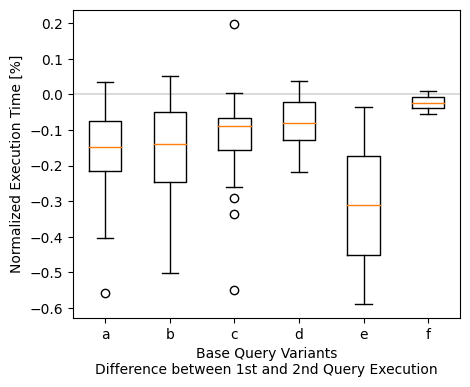

In [275]:
lbls = ['0-1', '1-2', '2-3', '3-4']
data = [
    df2[df2['query_ident'].str.contains('a')]['0-1_norm'].tolist(),
    df2[df2['query_ident'].str.contains('b')]['0-1_norm'].tolist(),
    df2[df2['query_ident'].str.contains('c')]['0-1_norm'].tolist(),
    df2[df2['query_ident'].str.contains('d')]['0-1_norm'].tolist(),
    df2[df2['query_ident'].str.contains('e')]['0-1_norm'].tolist(),
    df2[df2['query_ident'].str.contains('f')]['0-1_norm'].tolist()
]

plt.figure(figsize=(5,4))
plt.plot([0.5, 6.5], [0, 0], color='black', linewidth=0.2)
plt.boxplot(data, labels=['a', 'b', 'c', 'd', 'e', 'f'])
plt.ylabel('Normalized Execution Time [%]')
plt.xlabel('Base Query Variants\nDifference between 1st and 2nd Query Execution')
#plt.ylim([-0.5, 0.2])
plt.show()